This script is made to look through the double compact objects and test the new distinction mechanism we are proposing.

We define a critical a whereby, below this the binary will be ejected following a single dynamical interaction

$$a_{\mathrm{ej}} = 0.2 \frac{G}{v_{\mathrm{esc}}^{2}}\frac{m_{\mathrm{1}}m_{\mathrm{2}}}{m_{\mathrm{123}}}$$

In [1]:
import glob; import sys; import os
import pandas as pd
import numpy as np
import functions
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.lines import Line2D
from matplotlib.legend import Legend


pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 20}) # Set a good font size

rsol2AU = 0.00465047 # solar radii to au

In [2]:
def find_dir():
        '''
        Finds the likely location for the petar data files to be stored
        and gives the option to autoselect them.

        Returns data directory as a string
        '''

        # Finding possible directories where data could be stored
        directories = glob.glob('COMPAS_Output*')

        # Create a dictionary to store the available directories and index vals
        directoryList = {str(i): directories[i] for i in range(len(directories))}

        # Print the available directories
        print('Possible Directories:\n')
        for key, val in directoryList.items():
                print(key, ':', val)

        # Asking what directory the data is stored in and giving a list of potential directories
        chooseDirectory = input('\nWhat directory is the data stored in?  ')
        if chooseDirectory in directoryList.keys():
                dataDirectory = directoryList[str(chooseDirectory)]

        elif os.path.exists(str(chooseDirectory)):
                dataDirectory = str(chooseDirectory)

        else:
                print('Could not find directory\n')
                print('Quitting')
                sys.exit()

        return dataDirectory
    
def tdelay(ai,ei,m1,m2):
    """
    Calculates the GW timescale for a given binary
    semi-major axis, eccentricty and masses

    Input >>> ai = Semi Major axis [Rsol]
          ei = eccentricity
          m1, m2 = primary/secondary mass [Msol]

    Output >>> tGW = merger timescale [yrs]
    """


    # Defining useful constants
    Rsol = 6.9*(10**8.) #in meters
    MyrsToSec = 3.15*(10**13.) #time in sec
    tobs = 13*(10**3.)*MyrsToSec #Age of MilkyWay

    Gsi =  6.6*10**-11. #garavitaional constant in SI
    c = 3.*(10**8.) #velocity of light in seconds
    AUtoRsol = 214.9 #AU to Rsol
    Msol = 2.*(10**30) #Solar mass in kg
    betaWithoutMass = (64./5.)*(Gsi**3.0)/(c**5.0)
    daysToSeconds = 86400
    GyrsToSec = MyrsToSec * 1000
    YrsToSec = MyrsToSec/10**6


    #----tdelay

    #-- Choose ODE integrator
    backend = 'dopri5'

    l=len(ei)
    t_merger=[]

    for i in range(l):
        a0 = ai[i]*Rsol
        m_1 = m1[i]*Msol
        m_2 = m2[i]*Msol
        e0=ei[i]

        # If the initial ecc=0 then we have analytical solution
        if e0==0:
            beta = betaWithoutMass*m_1*m_2*(m_1+m_2)
            Te = (a0**4)/(4*beta)
            t_merger.append(Te/YrsToSec)
            continue

        c0Part1 = a0*(1. - e0**2.0)
        c0Part2 = (1.+(121./304.)*e0**2.)**(870./2299.)
        c0Part3 = e0**(12./19.)
        c0 = c0Part1/(c0Part2*c0Part3)
        beta = betaWithoutMass*m_1*m_2*(m_1+m_2)

        constant = (12./19.)*(c0**4.)/beta
        #print ((1. - e0**2.)**(3./2.))

        func = lambda e: constant*((e**(29./19.))*(1. + (121./304.)*e**2.)**(1181./2299.))/((1. - e**2.)**(3./2.))

        #-- Create ODE solver object
        solver = ode(func).set_integrator(backend)

        #-- Define initial and final parameters
        T0 = 0        #-- Initial value of T
        efinal = 1e-5 #-- Maximum value of e to integrate to

        solver.set_initial_value(T0, e0) #.set_f_params(r)

        sol = [] #-- Create an empty list to store the output in (here it will be the e list)

        #-- Define a function to append the output to our list
        def solout(e, T):
            sol.append([e, T/YrsToSec])
        solver.set_solout(solout)

        #-- This line actually integrates the ODE, no loop is required
        solver.integrate(efinal)

        #-- Convert list to array
        sol = np.asarray(sol, dtype=float)

        #-- Use sol to find the location

        e = sol[:, 0]
        T = np.abs(sol[:,1])

        t_max = max(np.abs(sol[:,1]))

        tm = t_max
        #print tm

        t_merger.append(tm)

    return np.asarray(t_merger)

def calcTrh(M, rh):
    '''
    Calculate the half-mass relaxation timescale for the cluster (Myrs)
    
    Input >>> M = cluster mass (Msol)
          >>> rh = cluster half-mass radius (pc)
    
    Output >>> trh = relaxation time (Myrs)
    '''
    
    #Define G 
    G = 0.00449830997959438 # pc^3 Msol^-1 Myrs^-2
    
    const = 0.138/(50*0.809) # Msol^-1
    
    return const * np.sqrt((M*rh**3)/(G))

def calcTint(M1, M2, a, Mcl, rh, Nbin, trh, delta=0.2):
    '''
    Calculates the interaction timescale for a hard encounter
    
    Input >>> M1 = mass 1 (Msol)
          >>> M2 = mass 2 (Msol)
          >>> a = semimajor axis (AU)
          >>> Mcl = cluster Mass (Msol)
          >>> rh = cluster half mass radius (pc)
          >>> Nbin = Number of hard binaries (int)
          >>> trh = relaxation time (Myrs)
          
    Output >>> tint = interaction timescale (Myrs)
    '''
    
    # Convert rh to AU
    rh*=pc2AU
    
    binary = (M1*M2)/a
    cluster = rh/(Mcl**2)
    
    return 25 * delta * binary * cluster * trh * Nbin

def calcMergeFromInteractions(m1, m2, semi, tint, N, delta=0.2):
    '''
    Calculate the affect of an interaction and see if it would 
    lead to a binary that merges. For each binary assume that the 
    binding energy increases by 40% and the eccentricity is drawn 
    from a thermal distribution averaged over 10 times
    
    Input >>> m1, m2 = primary and secondary binary mass (Msol)
          >>> Semi = semi-major axis (rsol)
          >>> tint = time for an interaction (Myrs)
          >>> N = Number of interactions to average over
          
    Output >>> avgtdelay = coalescence time averaged over 10 interactions (Myrs)
    '''
    
    # Number of binaries
    num=m1.size
    
    # Assume hard encounter increases binding energy by 40%
    new_a = semi/(1+delta)
    
    # Empty array to store all of the Tdelays
    delayTime_all = np.zeros(num)
    
    for i in range(N):
        # Draw an eccentricity from a thermal distribution for every binary
        esq = np.random.uniform(0,1,num)
        e = np.sqrt(esq)
        
        # Find the merger time for each of the binaries in Myrs and + interaction time
        tmerge = tdelay(ai=new_a, ei=e, m1=m1, m2=m2)/1e6
        delayTime = tmerge+tint
        
        # Append to the array we have
        delayTime_all = np.vstack((delayTime_all, delayTime))
    
    # for each binary average the tdelays
    delayTime_all = delayTime_all.T
    avgtdelay = np.mean(delayTime_all, axis=1)
    
    return avgtdelay
    

In [3]:
# Defining constants
G = 1.908e5 # R_sol*(M_sol)^-1*km^2*s^-2 
pc2AU = 206265 # Pc -> AU
Rsol2AU = 0.00465047 # Rsol -> AU
pcMyr2kms = 1.023 # Pc/Myr -> km/s

In [4]:
G*Rsol2AU/pc2AU

0.0043017946622063855

In [5]:
# Selecting directory
dataDir = find_dir()

Possible Directories:

0 : COMPAS_Output
1 : COMPAS_Output_1%sol_fallback
2 : COMPAS_Output_1%sol_noKicks
3 : COMPAS_Output_1%sol_reduced
4 : COMPAS_Output_1%_correctedEVO
5 : COMPAS_Output_1%_no_CHE
6 : COMPAS_Output_1%_pessCHE
7 : COMPAS_Output_alpha1_Z0.0001
8 : COMPAS_Output_largea_detailed
9 : COMPAS_Output_largea_detailed2
10 : COMPAS_Output_noBHKick_Z0.0001
11 : COMPAS_Output_noBHKick_Z0.001
12 : COMPAS_Output_noChem
13 : COMPAS_Output_PeTar_M100000
14 : COMPAS_Output_smalla_detailed
15 : COMPAS_Output_smalla_detailed2
16 : COMPAS_Output_sol_correctEVO
17 : COMPAS_Output_sol_no_CHE
18 : COMPAS_Output_SSE_Z0.00015
19 : COMPAS_Output_SSE_Z0.0015
20 : COMPAS_Output_test
21 : COMPAS_Output_test2
22 : COMPAS_Output_testSOL
23 : COMPAS_Output_Z0.0001
24 : COMPAS_Output_Z0.00015
25 : COMPAS_Output_Z0.0005
26 : COMPAS_Output_Z0.00075
27 : COMPAS_Output_Z0.001
28 : COMPAS_Output_Z0.0015
29 : COMPAS_Output_Z0.005
30 : COMPAS_Output_Z0.0075
31 : COMPAS_Output_Z0.01
32 : COMPAS_Output_Z0.01


What directory is the data stored in?   32


In [6]:
# Load in the double compact objects as well as the system parameters
DCO = pd.read_csv(os.path.join(dataDir, 'BSE_Double_Compact_Objects.csv'), skiprows=2)
SP = pd.read_csv(os.path.join(dataDir, 'BSE_System_Parameters.csv'), skiprows=2)
SN = pd.read_csv(os.path.join(dataDir, 'BSE_Supernovae.csv'), skiprows=2)


# Find the equilibrated at birth and remove them from the DCOs
EAB = SP.loc[SP['Equilibrated_At_Birth']==1] 
DCO.drop(DCO.loc[DCO['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)
SN.drop(SN.loc[SN['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)

# Remove the invalid values
invalidVals = SN.loc[(SN['SystemicSpeed '] == '          -nan')|(SN['SystemicSpeed '] == '          -nan')|(SN['SystemicSpeed '] == '          -nan')]
if len(invalidVals)>0:
    print('{} systems dropped'.format(len(invalidVals)))
    SN.drop(invalidVals.index, inplace=True)

SN = SN.astype({'SystemicSpeed ':'float64', 
                'ComponentSpeed(SN)':'float64', 
                'ComponentSpeed(CP)':'float64',
                'SemiMajorAxis ':'float64'})



# Specifically grab the BBHs
BBHMaster = DCO.loc[(DCO['Stellar_Type(1)']==14)&(DCO['Stellar_Type(2)']==14)].copy()
BBHMaster.reset_index(inplace=True, drop=True)

In [7]:
'''
Here we find all of the possible BH systems so that we can 
later find which have been retained.
'''

# Index for both SNs , only first and only last
SNDupIndex = SN.duplicated(subset='    SEED    ', keep=False)

SN1st = SN.loc[SN.duplicated(subset='    SEED    ', keep='last')]
SN2nd = SN.loc[SN.duplicated(subset='    SEED    ', keep='first')]

SN1st.reset_index(drop=True, inplace=True)
SN2nd.reset_index(drop=True, inplace=True)

# Two SNs
SNDup = SN.loc[SNDupIndex]
SNDup.reset_index(inplace=True, drop=True)

# Single SN
SNSing = SN.loc[~SNDupIndex]
SNSing.reset_index(inplace=True, drop=True)

# BH other star unbound and bound
BHSingUnbound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==1)]
BHSingBound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==0)]

BHSingUnbound.reset_index(inplace=True, drop=True)
BHSingBound.reset_index(inplace=True, drop=True)

# BBHs that remain bound
BBHBound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==0)]
BBHBound.reset_index(inplace=True, drop=True)

# BH other SN
BHElse = SN2nd.loc[((SN2nd['Stellar_Type(SN)']==14)&(SN2nd['Stellar_Type(CP)']!=14))|((SN2nd['Stellar_Type(CP)']==14)&(SN2nd['Stellar_Type(SN)']!=14))]
BHElse.reset_index(drop=True, inplace=True)

# BBHs that are not bound
BBHUnbound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==1)]
BBHUnbound.reset_index(inplace=True, drop=True)


In [37]:
SN.keys()

Index(['    SEED    ', 'Drawn_Kick_Magnitude(SN)',
       'Applied_Kick_Magnitude(SN)', 'Fallback_Fraction(SN)',
       'Orb_Velocity<SN', 'Kick_Magnitude(uK)', 'SN_Kick_Mean_Anomaly(SN)',
       'SN_Kick_Theta(SN)', 'SN_Kick_Phi(SN)', 'SN_Type(SN)',
       'Eccentricity<SN', ' Eccentricity ', 'SemiMajorAxis<SN',
       'SemiMajorAxis ', '      Time      ', 'Supernova_State', 'Unbound',
       'Stellar_Type(CP)', 'Stellar_Type(SN)', 'Stellar_Type_Prev(SN)',
       '   Mass(CP)   ', 'Mass_Total@CO(SN)', 'Mass_Core@CO(SN)',
       'Mass_CO_Core@CO(SN)', 'Mass_He_Core@CO(SN)', '   Mass(SN)   ',
       'Experienced_RLOF(SN)', 'MT_Donor_Hist(SN)', 'ComponentSpeed(SN)',
       'ComponentSpeed(CP)', 'SystemicSpeed ', 'Is_Hydrogen_Poor(SN)',
       'Record_Type'],
      dtype='object')

In [10]:
'''
I will define a range of cluster parameters and find the fractional populations that arise from each cluster.
Here we define populations in a simplistic way (characterising them based on the semi-major axis value compared to aej)

sigma = sqrt(G*Mcl/rh)

Assuming King profile with W0=7
vesc = 4.77*sigma 
'''
Mcl = np.array([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]) # 3 values of cluster mass (Msol) for open, globular and nuclear clusters densities

rh = 2.154 # pc
rh = 1
rhohArray = (Mcl/2)/(4/3*np.pi*rh**3)

# Empty array for the data to be stored
data_simple = {}


# Assumed perturber mass
m3=20 # Msol 

# Empty populatation arrays
pop1frac_simple=[]
pop2frac_simple=[]
pop3frac_simple=[]
soft_simple=[]

v_esc_array=[]

# Empty retained fraction array
tot_bound = []
tot_unbound = []
total_retained = []

print('##########STARTING##########\n')
for mass in Mcl:
    BBH_simple = BBHMaster.copy()
    
    rhoh = (mass/2)/(4/3*np.pi*rh**3)
    
    print('Mass = {:.3g} Msol'.format(mass))
    print('Rh = {:.3g} pc'.format(rh))
    print('rho = {:.3g} Msol/pc^3\n'.format(rhoh))
    
    # Properties of the cluster
    sigma_sq = (G*Rsol2AU/pc2AU)*mass/rh # vel disp km/s
    vesc = 4.77*np.sqrt(sigma_sq) # esc vel km/s
    
    v_esc_array.append(vesc)
    
    print('Sigma = {:.3g} km/s'.format(np.sqrt(sigma_sq)))
    print('Vesc = {:.3g} km/s\n'.format(vesc))
    
    # Calculate relaxation time for cluster
    trh = calcTrh(M=mass, rh=rh)
    
    # Classify every BBH initially as pop 0 to be changed later
    BBH_simple['Pop'] = np.zeros(len(BBH_simple))
    
    # Find the BBH's that escape solely from SN kicks
    esc=[]

    for name in BBH_simple['    SEED    ']:
        # Find both SN information
        temp = SN.loc[SN['    SEED    '] == name]

        if (temp['SystemicSpeed '].values<vesc).all():
            esc.append(0)
        elif temp['SystemicSpeed '].values[0]>=vesc:
            esc.append(1)
        elif temp['SystemicSpeed '].values[1]>=vesc:
            esc.append(2)
    
    # Add this as column
    esc = np.asarray(esc)
    BBH_simple['Escaped'] = esc
    
    # Classify as pop1
    BBH_simple['Pop'].loc[(BBH_simple['Escaped']!=0)&(BBH_simple['Merges_Hubble_Time']==1)] = int(1)

    # Find the BBHs that are hard
    # Find the ah cut off for every binary
    mu = (BBH_simple['   Mass(1)    ']*BBH_simple['   Mass(2)    '])/(BBH_simple['   Mass(1)    ']+BBH_simple['   Mass(2)    '])
    ah = (G*Rsol2AU)*mu/sigma_sq

    # Classify a binary as hard if its a < ah
    hard  = np.zeros(len(BBH_simple))
    hard[np.where(BBH_simple['SemiMajorAxis@DCO']<=ah)] = int(1)

    # Add to the BBH file
    BBH_simple['Hard'] = hard
    
    # Find interaction time for all binaries and add as column
    tint = calcTint(M1=BBH_simple['   Mass(1)    '], M2=BBH_simple['   Mass(2)    '], a=BBH_simple['SemiMajorAxis@DCO'], Mcl=mass, rh=rh, trh=trh)
    BBH_simple['Tint']=tint
    
    # Find pop 1 binaries that don't escape but merge before an interaction
    retainedMerge = (BBH_simple['Merges_Hubble_Time']==1)&(BBH_simple['Escaped']==0)&(BBH_simple['Hard']==1)
    mergeBeforeInt = (BBH_simple['Tint']+BBH_simple['      Time      '])>BBH_simple['Coalescence_Time']
    BBH_simple['Pop'].loc[retainedMerge & mergeBeforeInt] = int(1)
    
    # Finding index for all pop1
    pop1 = BBH_simple['Pop']==1
    
    # Finding the ejection semi-major axis and add to the dataframe (assume same perturber mass for all interactions)
    aej = 0.2*(G)/(vesc**2)*(BBH_simple['   Mass(1)    ']*BBH_simple['   Mass(2)    '])/(BBH_simple['   Mass(1)    ']+BBH_simple['   Mass(2)    ']+m3) # Rsol
    aej*=Rsol2AU
    
    # Add as a column
    BBH_simple['aej'] = aej
    
    # In this simple model we define pop 2 as BBHs below the aej value that are not pop 1
    belowAej = (BBH_simple['SemiMajorAxis@DCO']<=BBH_simple['aej'])
    pop2 = (belowAej)&(BBH_simple['Pop']!=1)
    mergingIndex = (BBH_simple['Merges_Hubble_Time']==1)
    BBH_simple['Pop'].loc[pop2] = 2
    
        
    # Pop 3 are BBHs that are hard and so will likely merge at some point but experience more than 1 interaction and are not ejected
    pop3 = ~pop1 & ~pop2 & (BBH_simple['SemiMajorAxis@DCO']>BBH_simple['aej']) & (BBH_simple['Hard']==1)
    BBH_simple['Pop'].loc[pop3] = 3 
    
 
    total = len(BBH_simple)
    
    
    print('Pop 1 frac: {:.3g}'.format(len(BBH_simple.loc[pop1])/total))
    print('Pop 2 frac: {:.3g}'.format(len(BBH_simple.loc[pop2])/total))
    print('Pop 3 frac: {:.3g}\n'.format(len(BBH_simple.loc[pop3])/total))
    
    pop1frac_simple.append(len(BBH_simple.loc[pop1])/total)
    pop2frac_simple.append(len(BBH_simple.loc[pop2])/total)

    pop3frac_simple.append(len(BBH_simple.loc[pop3])/total)
    soft_simple.append(len(BBH_simple.loc[BBH_simple['Pop']==0])/total)
    

    # Here we ensure that the primary mass is labelled as m1
    primMass = BBH_simple['   Mass(1)    ']<BBH_simple['   Mass(2)    ']
    BBH_simple.loc[primMass, ['   Mass(1)    ', '   Mass(2)    ', 'Stellar_Type(1)', 'Stellar_Type(2)']] = BBH_simple.loc[primMass, [ '   Mass(2)    ', '   Mass(1)    ', 'Stellar_Type(2)', 'Stellar_Type(1)']]    
    
    data_simple[mass] = BBH_simple
    
    
    ############################################
    # Reset the counters
    retainedSingle=0
    retainedBound=0
    
    # This last part will calculate the fraction of retained binaries (containing at least one BH) with the cluster 
    # Those systems that form a BH but the second star never goes SN
    retainedSingle+=len(BHSingUnbound.loc[BHSingUnbound['ComponentSpeed(SN)']<vesc])
    retainedBound+=len(BHSingBound.loc[BHSingBound['ComponentSpeed(SN)']<vesc])

    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]
    
    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]
    
    retainedBound+=2*len(BBHRetain)
    
    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)])
    
    # BHElse on Second
    index = BHElse['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedBound+=len(BHElse.loc[(index)&(BHElse['SystemicSpeed ']<vesc)&(BHElse['Unbound']==0)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(SN)']<vesc)&(BHElse['Stellar_Type(SN)']==14)&(BHElse['Unbound']==1)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(CP)']<vesc)&(BHElse['Stellar_Type(CP)']==14)&(BHElse['Unbound']==1)])
    
    # retainedUnbound on first
    retainedSingle+=len(retainedSN.loc[retainedSN['Stellar_Type(SN)']==14])
    
    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    retainedSingle+=len(SN2nd[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)])
    
    # Append to the fractional arrays
    totalretained=retainedSingle+retainedBound
    tot_bound.append(retainedBound)
    tot_unbound.append(retainedSingle)
    total_retained.append(totalretained)
    
    print('##############################\n')
    
tot_bound = np.asarray(tot_bound)
tot_unbound = np.asarray(tot_unbound)
total_retained = np.asarray(total_retained)



##########STARTING##########

Mass = 100 Msol
Rh = 1 pc
rho = 11.9 Msol/pc^3

Sigma = 0.656 km/s
Vesc = 3.13 km/s

Pop 1 frac: 0.025
Pop 2 frac: 0.381
Pop 3 frac: 0.555

##############################

Mass = 1e+03 Msol
Rh = 1 pc
rho = 119 Msol/pc^3

Sigma = 2.07 km/s
Vesc = 9.89 km/s

Pop 1 frac: 0.025
Pop 2 frac: 0.308
Pop 3 frac: 0.433

##############################

Mass = 1e+04 Msol
Rh = 1 pc
rho = 1.19e+03 Msol/pc^3

Sigma = 6.56 km/s
Vesc = 31.3 km/s



KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))


ax.plot(v_esc_array, tot_bound/total_retained, color='black', linestyle=':', label='Binary fraction')
#ax.plot(v_esc_array, tot_unbound/total_retained, color='black', linestyle='-')


ax.plot(v_esc_array, pop1frac_simple, color='tab:orange', label='Pop I')
# ax.plot(v_esc_array, pop2frac_simple_SEmerge, color='tab:green', label='Pop 2 - SE merge', linestyle='--')
# ax.plot(v_esc_array, pop2frac_simple_intmerge, color='tab:green', label='Pop 2 - int merge', linestyle=':')
ax.plot(v_esc_array, pop2frac_simple, color='tab:green', label='Pop II')
ax.plot(v_esc_array, pop3frac_simple, color='tab:blue', label='Pop III')
#ax.plot(v_esc_array, soft_simple, color='black', label='Soft BBH')

ax.legend(loc='upper right', fontsize=18)
#ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_xlabel('Cluster rh ($M_{\odot}/r_{\mathrm{h}}^{3}$)')
ax.set_xlabel('$v_{\mathrm{esc}} \ \mathrm{kms}^{-1}$ ', fontsize=22)

#ax.set_xlabel('$M_{\mathrm{cl}} \ (M_{\odot})$ ', fontsize=22)

ax.set_ylabel('$f_{\mathrm{pop}}$', fontsize=22)

In [156]:
fig.savefig(os.path.join(dataDir, 'PopFractions.pdf'), dpi=100)

In [162]:
'''
Splitting the pop2 into those that would merge due to SE (lower limit)
and those that would merge after the averaged affect over 10 interactions

Finding lower estimate on pop 3 merging fraction by assuming they all reach aej
calculate 10 interactions and average over
'''

pop1frac_simple_inside = []
pop1frac_simple_outside = []

pop2frac_simple_SEmerge = []
pop2frac_simple_intmerge = []

pop3frac_simple_intmerge = []

for key in data_simple.keys():
    BBH_simple = data_simple[key]
    total = len(BBH_simple)
    
    # Find the pop1, pop2 and pop3
    pop1 = (BBH_simple['Pop']==1)
    pop2 = (BBH_simple['Pop']==2)
    pop3 = (BBH_simple['Pop']==3)
    
    # Find those that binaries that are already in a merging regime after SE
    mergingIndex = (BBH_simple['Merges_Hubble_Time']==1)
    
    # Calculating the mergers due to an interaction
    if len(BBH_simple.loc[pop2])>0:
        avgMerge = calcMergeFromInteractions(m1=BBH_simple['   Mass(1)    '].loc[pop2].values, 
                                             m2=BBH_simple['   Mass(2)    '].loc[pop2].values,
                                             semi=BBH_simple['SemiMajorAxis@DCO'].loc[pop2].values/Rsol2AU,
                                             tint=BBH_simple['Tint'].loc[pop2].values+BBH_simple['      Time      '].loc[pop2].values,
                                             N=10)
        
        # Finding the number that merge within a hubble time
        numIntMerge = len(avgMerge[avgMerge<=13.7e3])
    
    else:
        numIntMerge = 0
    
    # Lower limit for mergers is how many would merge once they reach aej
    if len(BBH_simple.loc[pop3])>0:
        # Find roughly how many interactions it takes to reach the aej
        numInt = np.round(np.log10(BBH_simple['SemiMajorAxis@DCO'].loc[pop3].values/BBH_simple['aej'].loc[pop3].values)/np.log10(1.4))
        avgMerge = calcMergeFromInteractions(m1=BBH_simple['   Mass(1)    '].loc[pop3].values,
                                             m2=BBH_simple['   Mass(2)    '].loc[pop3].values,
                                             semi=BBH_simple['aej'].loc[pop3].values/Rsol2AU,
                                             tint=BBH_simple['Tint'].loc[pop3].values*numInt+BBH_simple['      Time      '].loc[pop3].values,
                                             N=10)
        
        numInt3Merge = len(avgMerge[avgMerge<=13.7e3])
        
    else:
        numInt3Merge = 0
        
    
    totalMergers = len(BBH_simple.loc[pop1]) + numIntMerge + numInt3Merge
    
    print('###########################')
    print('Pop 1 mergers (inside): {:.3g}'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']==0)])/totalMergers))
    print('Pop 1 mergers (outside): {:.3g}\n'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']>0)])/totalMergers))
    
    print('Pop 2 frac merging from SE: {:.3g}'.format(len(BBH_simple.loc[(pop2)&(mergingIndex)])/totalMergers))
    print('Pop 2 frac merging from int: {:.3g}\n'.format(numIntMerge/totalMergers))
    
    print('Pop 3 frac merging from interaction once aej reached: {:.3}\n'.format(numInt3Merge/totalMergers))

    pop1frac_simple_inside.append(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']==0)])/totalMergers)
    pop1frac_simple_outside.append(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']>0)])/totalMergers)

    pop2frac_simple_SEmerge.append(len(BBH_simple.loc[(pop2)&(mergingIndex)])/totalMergers)
    pop2frac_simple_intmerge.append(numIntMerge/totalMergers)
    
    pop3frac_simple_intmerge.append(numInt3Merge/totalMergers)

pop1frac_simple_inside = np.asarray(pop1frac_simple_inside)
pop1frac_simple_outside = np.asarray(pop1frac_simple_outside)

pop2frac_simple_SEmerge = np.asarray(pop2frac_simple_SEmerge)
pop2frac_simple_intmerge = np.asarray(pop2frac_simple_intmerge)

pop3frac_simple_intmerge = np.asarray(pop3frac_simple_intmerge)

###########################
Pop 1 mergers (inside): 0.347
Pop 1 mergers (outside): 0.653

Pop 2 frac merging from SE: 0
Pop 2 frac merging from int: 0

Pop 3 frac merging from interaction once aej reached: 0.0

###########################
Pop 1 mergers (inside): 0.283
Pop 1 mergers (outside): 0.475

Pop 2 frac merging from SE: 0.042
Pop 2 frac merging from int: 0.242

Pop 3 frac merging from interaction once aej reached: 0.0

###########################
Pop 1 mergers (inside): 0.21
Pop 1 mergers (outside): 0.32

Pop 2 frac merging from SE: 0.256
Pop 2 frac merging from int: 0.47

Pop 3 frac merging from interaction once aej reached: 0.0

###########################
Pop 1 mergers (inside): 0.0689
Pop 1 mergers (outside): 0.0586

Pop 2 frac merging from SE: 0.236
Pop 2 frac merging from int: 0.237

Pop 3 frac merging from interaction once aej reached: 0.635

###########################
Pop 1 mergers (inside): 0.0507
Pop 1 mergers (outside): 0.000398

Pop 2 frac merging from SE: 0
Pop 2 f

Text(0, 0.5, '$f_{\\mathrm{merge}}$')

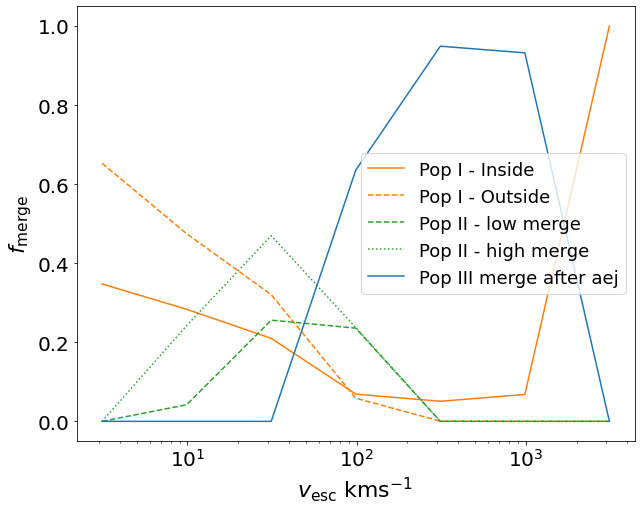

In [163]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(v_esc_array, pop1frac_simple_inside, color='tab:orange', label='Pop I - Inside')
ax.plot(v_esc_array, pop1frac_simple_outside, color='tab:orange', label='Pop I - Outside', linestyle='--')

ax.plot(v_esc_array, pop2frac_simple_SEmerge, color='tab:green', label='Pop II - low merge', linestyle='--')
ax.plot(v_esc_array, pop2frac_simple_intmerge, color='tab:green', label='Pop II - high merge', linestyle=':')

ax.plot(v_esc_array, pop3frac_simple_intmerge, color='tab:blue', label='Pop III merge after aej')


ax.legend(loc='center right', fontsize=18)
#ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_xlabel('Cluster rh ($M_{\odot}/r_{\mathrm{h}}^{3}$)')
ax.set_xlabel('$v_{\mathrm{esc}} \ \mathrm{kms}^{-1}$ ', fontsize=22)

#ax.set_xlabel('$M_{\mathrm{cl}} \ (M_{\odot})$ ', fontsize=22)

ax.set_ylabel('$f_{\mathrm{merge}}$', fontsize=22)

In [159]:
fig.savefig(os.path.join(dataDir, 'mergeFractions.pdf'), dpi=100)

Text(0, 0.5, 'aej')

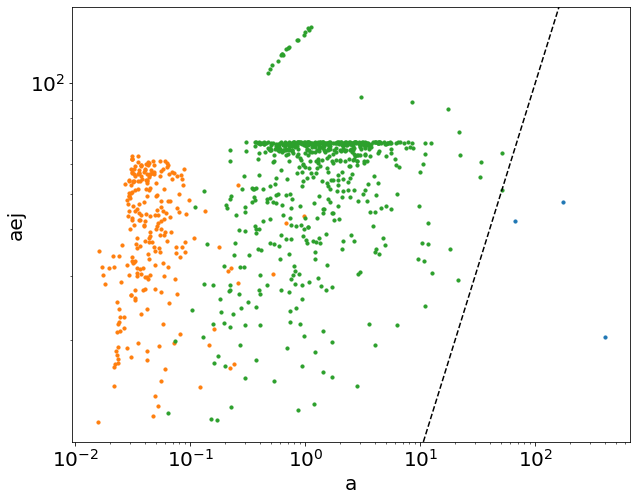

In [139]:
test = data_simple[1e2]
                   

pop1 = (test['Pop']==1)
pop2 = (test['Pop']==2)
pop3 = (test['Pop']==3)
pop4 = (test['Pop']==0)


plt.figure(figsize=(10,8))
plt.scatter(test['SemiMajorAxis@DCO'].loc[pop1], test['aej'].loc[pop1], color='tab:orange', s = 10)
plt.scatter(test['SemiMajorAxis@DCO'].loc[pop2], test['aej'].loc[pop2], color='tab:green', s = 10)
plt.scatter(test['SemiMajorAxis@DCO'].loc[pop3], test['aej'].loc[pop3], color='tab:blue', s = 10)
plt.scatter(test['SemiMajorAxis@DCO'].loc[pop4], test['aej'].loc[pop4], color='tab:red', s = 10)


plt.axline([np.mean(test['aej'].values), np.mean(test['aej'].values)], slope=1, linestyle='--', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
plt.ylabel('aej')

##########STARTING##########

Mass = 100 Msol
Rh = 1 pc
rho = 11.9 Msol/pc^3

Sigma = 0.656 km/s
Vesc = 3.13 km/s

Pop 1 frac: 0.287
Pop 2 frac: 0.709
Pop 3 frac: 0.00347

Mass = 1e+03 Msol
Rh = 1 pc
rho = 119 Msol/pc^3

Sigma = 2.07 km/s
Vesc = 9.89 km/s

Pop 1 frac: 0.285
Pop 2 frac: 0.662
Pop 3 frac: 0.0428

Mass = 1e+04 Msol
Rh = 1 pc
rho = 1.19e+03 Msol/pc^3

Sigma = 6.56 km/s
Vesc = 31.3 km/s

Pop 1 frac: 0.197
Pop 2 frac: 0.241
Pop 3 frac: 0.507

Mass = 1e+05 Msol
Rh = 1 pc
rho = 1.19e+04 Msol/pc^3

Sigma = 20.7 km/s
Vesc = 98.9 km/s

Pop 1 frac: 0.0787
Pop 2 frac: 0.115
Pop 3 frac: 0.76

Mass = 1e+06 Msol
Rh = 1 pc
rho = 1.19e+05 Msol/pc^3

Sigma = 65.6 km/s
Vesc = 313 km/s

Pop 1 frac: 0.00116
Pop 2 frac: 0
Pop 3 frac: 0.623

Mass = 1e+07 Msol
Rh = 1 pc
rho = 1.19e+06 Msol/pc^3

Sigma = 207 km/s
Vesc = 989 km/s

Pop 1 frac: 0
Pop 2 frac: 0
Pop 3 frac: 0.257

Mass = 1e+08 Msol
Rh = 1 pc
rho = 1.19e+07 Msol/pc^3

Sigma = 656 km/s
Vesc = 3.13e+03 km/s

Pop 1 frac: 0
Pop 2 frac: 0

Text(0, 0.5, 'Population frac')

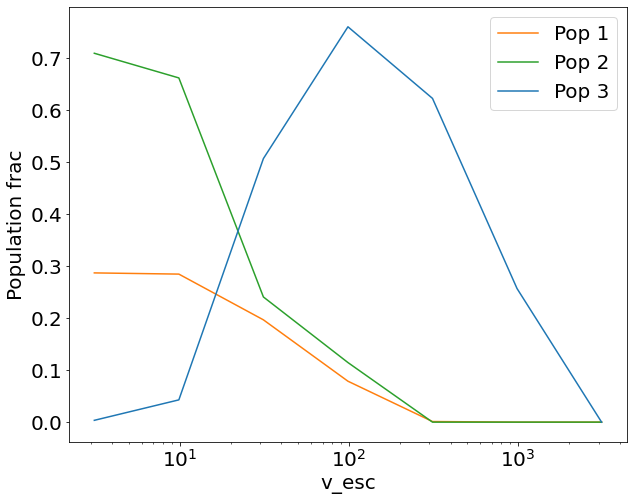

In [140]:
'''
I will define a range of cluster parameters and find the fractional populations that arise from each cluster.

sigma = sqrt(G*Mcl/rh)

Assuming King profile with W0=7
vesc = 4.77*sigma 
'''

# Empty array for the data to be stored
data = {}


pop1frac=[]
pop2frac=[]
pop3frac=[]
soft=[]

v_esc_array=[]

fig, ax = plt.subplots(figsize=(10,8))
print('##########STARTING##########\n')
for mass in Mcl:
    BBH = BBHMaster.copy()
    
    rhoh = (mass/2)/(4/3*np.pi*rh**3)
    
    print('Mass = {:.3g} Msol'.format(mass))
    print('Rh = {:.3g} pc'.format(rh))
    print('rho = {:.3g} Msol/pc^3\n'.format(rhoh))
    
    # Properties of the cluster
    sigma_sq = (G*Rsol2AU/pc2AU)*mass/rh # vel disp km/s
    vesc = 4.77*np.sqrt(sigma_sq) # esc vel km/s
    
    v_esc_array.append(vesc)
    
    print('Sigma = {:.3g} km/s'.format(np.sqrt(sigma_sq)))
    print('Vesc = {:.3g} km/s\n'.format(vesc))
    
    # Calculate relaxation time for cluster
    trh = calcTrh(M=mass, rh=rh)
    
    # Classify every BBH initially as pop 0 to be changed later
    BBH['Pop'] = np.zeros(len(BBH))
    
    # Find the BBH's that escape solely from SN kicks
    esc=[]

    for name in BBH['    SEED    ']:
        # Find both SN information
        temp = SN.loc[SN['    SEED    '] == name]

        if (temp['SystemicSpeed ']<vesc).all():
            esc.append(0)
        elif temp['SystemicSpeed '].values[0]>=vesc:
            esc.append(1)
        elif temp['SystemicSpeed '].values[1]>=vesc:
            esc.append(2)
    
    # Add this as column
    esc = np.asarray(esc)
    BBH['Escaped'] = esc
    
    # Classify as pop1
    BBH['Pop'].loc[(BBH['Escaped']!=0)&(BBH['Merges_Hubble_Time']==1)] = int(1)

    # Find the BBHs that are hard
    # Find the ah cut off for every binary
    mu = (BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    '])
    ah = (G*Rsol2AU)*mu/sigma_sq

    # Classify a binary as hard if its a < ah
    hard  = np.zeros(len(BBH))
    hard[np.where(BBH['SemiMajorAxis@DCO']<=ah)] = int(1)

    # Add to the BBH file
    BBH['Hard'] = hard
    
    # Find interaction time for all binaries and add as column
    tint = calcTint(M1=BBH['   Mass(1)    '], M2=BBH['   Mass(2)    '], a=BBH['SemiMajorAxis@DCO'], Mcl=mass, rh=rh, trh=trh)
    BBH['Tint']=tint
    
    # Find pop 1 binaries that don't escape but merge before an interaction
    retainedMerge = (BBH['Merges_Hubble_Time']==1)&(BBH['Escaped']==0)&(BBH['Hard']==1)
    mergeBeforeInt = (BBH['Tint']+BBH['      Time      '])>BBH['Coalescence_Time']
    BBH['Pop'].loc[retainedMerge & mergeBeforeInt] = int(1)
    
    # Finding index for all pop1
    pop1 = BBH['Pop']==1
    
    # Finding the critical semi-major axis and add to the dataframe (assume same perturber mass for all interactions)
    aej = 0.2*(G)/(vesc**2)*(BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    ']+m3) # Rsol
    aej*=Rsol2AU
    
    # Add as a column
    BBH['aej'] = aej
    
    # For all BBHs calcuate a new tdelay assuming
    # Assume strong interaction increases binding energy by 20%
    new_a = BBH['SemiMajorAxis@DCO']/1.2

    # draw new ecc^2 from thermal distribution
    new_e_sq = np.random.uniform(0,1,len(BBH))
    
    # Calculate a new tdelay from these semimajor axis
    newTdelay = tdelay(ai=new_a/Rsol2AU, ei=np.sqrt(new_e_sq), m1=BBH['   Mass(1)    '], m2=BBH['   Mass(2)    '])/1e6
    BBH['newTdelay'] = newTdelay

    # Find all of the BBHs that are ejected after a single interaction and espcecially those that merge
    oneIntEject = (BBH['SemiMajorAxis@DCO']<=BBH['aej'])&(~pop1)
    oneIntEjectMerge = (oneIntEject)&((BBH['newTdelay']+BBH['Tint']+BBH['      Time      '])<=13.7e3)
    
    # Add these as pop2 
    BBH['Pop'].loc[oneIntEjectMerge] = int(2)
       
    # Find the BBHs that are not ejected by the interaction but are now in a merging regime
    oneIntMerge = (~oneIntEject)&(~pop1)&(BBH['newTdelay']+BBH['Tint']+BBH['      Time      ']<=13.7e3)
    
   # Calculate a second interaction timescale
    Tint2 = BBH['Tint']*1.2
    
    # Pop 2 are also defined by merging before a successive interaction after the first
    oneIntMergeBeforeNext = (oneIntMerge)&(BBH['newTdelay']<=Tint2)
 
    # Add these also as pop2
    #BBH['Pop'].loc[oneIntMergeBeforeNext] = int(2)
    
    
    ###### TEST #####
    #BBH['Pop'].loc[oneIntMerge] = int(2)
    
    BBH['Pop'].loc[(BBH['SemiMajorAxis@DCO']<=BBH['aej'])&(BBH['Pop']!=1)] = 2
    
    
    # find pop2 indices
    pop2 = BBH['Pop'] == 2
    
    # Pop 3 are BBHs that are hard and so will likely merge at some point but experience more than 1 interaction and are not ejected
    pop3 = ~pop1 & ~pop2 & (new_a>BBH['aej']) & (BBH['Hard']==1)
    BBH['Pop'].loc[pop3] = 3 
    
 
    total = len(BBH)
    
    
    print('Pop 1 frac: {:.3g}'.format(len(BBH.loc[pop1])/total))
    print('Pop 2 frac: {:.3g}'.format(len(BBH.loc[pop2])/total))
    print('Pop 3 frac: {:.3g}\n'.format(len(BBH.loc[pop3])/total))
    
    pop1frac.append(len(BBH.loc[pop1])/total)
    pop2frac.append(len(BBH.loc[pop2])/total)
    pop3frac.append(len(BBH.loc[pop3])/total)
    soft.append(len(BBH.loc[BBH['Pop']==0])/total)
    

    # Here we ensure that the primary mass is labelled as m1
    primMass = BBH['   Mass(1)    ']<BBH['   Mass(2)    ']
    BBH.loc[primMass, ['   Mass(1)    ', '   Mass(2)    ', 'Stellar_Type(1)', 'Stellar_Type(2)']] = BBH.loc[primMass, [ '   Mass(2)    ', '   Mass(1)    ', 'Stellar_Type(2)', 'Stellar_Type(1)']]    
    
    data[mass] = BBH

    
ax.plot(v_esc_array, pop1frac, color='tab:orange', label='Pop 1')
ax.plot(v_esc_array, pop2frac, color='tab:green', label='Pop 2')
ax.plot(v_esc_array, pop3frac, color='tab:blue', label='Pop 3')
#ax.plot(v_esc_array, soft, color='black', label='Soft BBHs')

#ax.scatter(BBH['SemiMajorAxis@DCO'].loc[pop1], BBH['aej'].loc[pop1], alpha=0.5, s=20, color='tab:orange')
#ax.scatter(BBH['SemiMajorAxis@DCO'].loc[pop2], BBH['aej'].loc[pop2], alpha=0.5, s=20, color='tab:green')   
#ax.scatter(BBH['SemiMajorAxis@DCO'].loc[pop3], BBH['aej'].loc[pop3], alpha=0.5, s=20, color='tab:blue')   
#ax.scatter(BBH['SemiMajorAxis@DCO'].loc[BBH['Pop']==0], BBH['aej'].loc[BBH['Pop']==0], alpha=0.5, s=10, color='tab:red')   



ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Cluster rh ($M_{\odot}/r_{\mathrm{h}}^{3}$)')
ax.set_xlabel('v_esc')
ax.set_ylabel('Population frac')

In [587]:
primMass = BBH['   Mass(1)    ']<BBH['   Mass(2)    ']
print(primMass)

BBH.loc[primMass, ['   Mass(1)    ', '   Mass(2)    ', 'Stellar_Type(1)', 'Stellar_Type(2)']] = BBH.loc[primMass, [ '   Mass(2)    ', '   Mass(1)    ', 'Stellar_Type(2)', 'Stellar_Type(1)']]

0        False
1        False
2        False
3        False
4         True
         ...  
13781    False
13782    False
13783    False
13784    False
13785    False
Length: 13786, dtype: bool


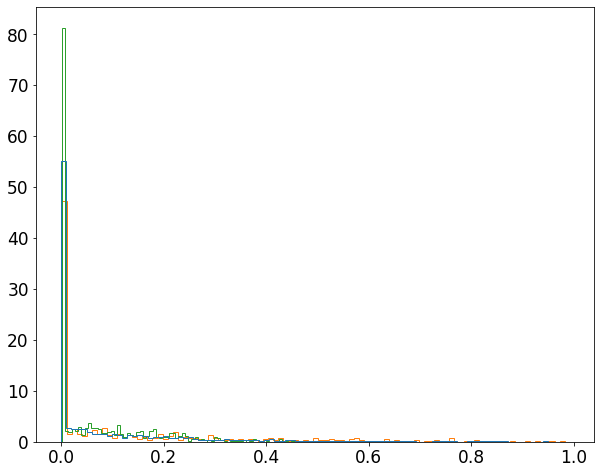

In [604]:
fig, ax = plt.subplots(figsize=(10,8))

bins = np.logspace(0, np.log10(2.5e2), 100)

ax.hist(BBH['Eccentricity@DCO'].loc[pop1], bins=100, histtype='step', cumulative=False, density=True, color='tab:orange')
ax.hist(BBH['Eccentricity@DCO'].loc[pop2], bins=100, histtype='step', cumulative=False, density=True, color='tab:green')   
ax.hist(BBH['Eccentricity@DCO'].loc[pop3], bins=100, histtype='step', cumulative=False, density=True, color='tab:blue');

#ax.set_xscale('log')

In [533]:
'''
Here we need to check if the BBH will be ejected by the SNs or if it will remain in the cluster

Assume the escape velocity is Vesc = 54.4 km/s (intial half mass esc velocity for M=100,000 cluster 
Assuming W0=7)
'''
sigma_sq = (G*Rsol2AU/pc2AU)*mass/rh # vel disp km/s
sigma = np.sqrt(sigma_sq)
escVel = 4.77*np.sqrt(sigma_sq) # esc vel km/s

# Calculate relaxation time for cluster
trh = calcTrh(M=mass, rh=rh)

esc=[]

for name in BBH['    SEED    ']:
    # Find both SN information
    temp = SN.loc[SN['    SEED    '] == name]
    
    if (temp['Applied_Kick_Magnitude(SN)']<escVel).all():
        esc.append(0)
    elif temp['Applied_Kick_Magnitude(SN)'][0]>=escVel:
        esc.append(1)
    elif temp['Applied_Kick_Magnitude(SN)'][1]>=escVel:
        esc.append(2)
        
esc = np.asarray(esc)

BBH['Escaped'] = esc

'''
Now Find if they are classed as hard binaries
'''
# Find the ah cut off for every binary
mu = (BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    '])
ah = (G*Rsol2AU)*mu/sigma**2

# Classify a binary as hard if its a < ah
hard  = np.zeros(len(BBH))
hard[np.where(BBH['SemiMajorAxis@DCO']<=ah)] = 1

# Add to the BBH file
BBH['Hard'] = hard
BBH.keys()

Index(['    SEED    ', 'SemiMajorAxis@DCO', 'Eccentricity@DCO',
       '   Mass(1)    ', 'Stellar_Type(1)', '   Mass(2)    ',
       'Stellar_Type(2)', 'Coalescence_Time', '      Time      ',
       'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'Pop',
       'Escaped', 'Hard', 'Tint', 'acr', 'newTdelay'],
      dtype='object')

In [534]:
pop1 = BBH.loc[(BBH['Escaped']==1)&(BBH['Merges_Hubble_Time']==1)]
len(pop1)
#fig, ax = plt.subplots(figsize=(10,8))
#
#ax.hist(pop1['   Mass(1)    '], bins=100, histtype='step')
#ax.hist(pop1['   Mass(2)    '], bins=100, histtype='step')


32

For all of the binaries that remain in the cluster we calculate the critical radii below which they should be ejected after a single interaction. 

We assume a typical perturber mass of $20 M_{\odot}$

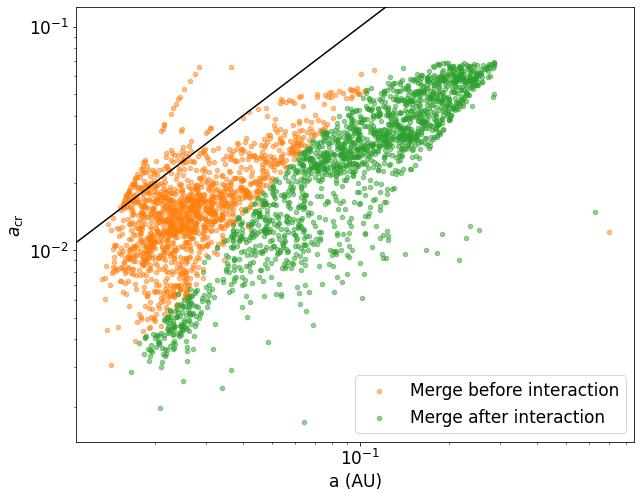

In [537]:
# Finding the critical semi-major axis and add to the dataframe
aej = 0.2*(G)/(escVel**2)*(BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    ']+20) # Rsol
aej*=Rsol2AU

BBH['aej'] = aej

# Finding the typical timescale for an interaction and adding this to the dataframe
#trh = 433.73 # Myrs
#trh = 86 # Myrs

# Calculate interaction timescale
tint = 10*(BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(1e5)**2*(2.154*pc2AU)/(2*BBH['SemiMajorAxis@DCO'])*trh
BBH['Tint'] = tint

# Plot a scatter of the values
retainedNsoft = (BBH['Escaped']==0)&(BBH['Merges_Hubble_Time']!=1)&(BBH['Hard']==0) # Blue ^ in the plots

retained = (BBH['Escaped']==0)&(BBH['Merges_Hubble_Time']!=1)&(BBH['Hard']==1) # Blue in the plots
retainednMerge = (BBH['Escaped']==0)&(BBH['Merges_Hubble_Time']==1)&(BBH['Hard']==1) # Orange in the plots
mergeBeforeInt = ((BBH['      Time      ']+BBH['Tint'])>BBH['Coalescence_Time'])&(BBH['Hard']==1)

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retainedNsoft], BBH['aej'].loc[retainedNsoft], s=20, color='tab:purple', alpha=0.5, label='Soft Binary')
ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retained], BBH['aej'].loc[retained], s=20, color='tab:blue', alpha=0.5, label='No merge')
ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retainednMerge & mergeBeforeInt], BBH['aej'].loc[retainednMerge & mergeBeforeInt], color='tab:orange', s=20, alpha=0.5, label='Merge before interaction')
ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retainednMerge & ~mergeBeforeInt], BBH['aej'].loc[retainednMerge & ~mergeBeforeInt], s=20, alpha=0.5, color='tab:green', label='Merge after interaction')

# Formatting Plot
ax.axline([1e-1, 1e-1], slope=1, color='black')
#ax.axvline(ah, 0, 1, color='red')
ax.set_xlabel('a (AU)')
ax.set_ylabel('$a_{\mathrm{cr}}$')


ax.legend(loc='best')
ax.set_xscale('log')
ax.set_yscale('log')


In [536]:
'''
Find those that have a < aej and find out if the reduce semi-major axis allows them to merge
'''
retainedNoMergeLowA = (BBH['SemiMajorAxis@DCO']<=BBH['aej'])&(retained)
retainedNoMergeLowA = retained

temp = BBH.loc[retainedNoMergeLowA]

# Assume strong interaction increases binding energy by 20%
new_a = temp['SemiMajorAxis@DCO']/1.2

# draw new ecc from thermal distribution
new_e_sq = np.random.uniform(0,1,len(temp))

# Calculate a new tdelay from these semimajor axis
newTdelay = tdelay(ai=new_a*215.032, ei=np.sqrt(new_e), m1=temp['   Mass(1)    '], m2=temp['   Mass(2)    '])/1e6
temp['newTdelay'] = newTdelay

IndexError: index 2685 is out of bounds for axis 0 with size 2685

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(temp['newTdelay'], temp['Coalescence_Time'], s=10)

plt.axvline(13.7e3, 0, 1, color='black')

In [451]:
len(temp)

5592

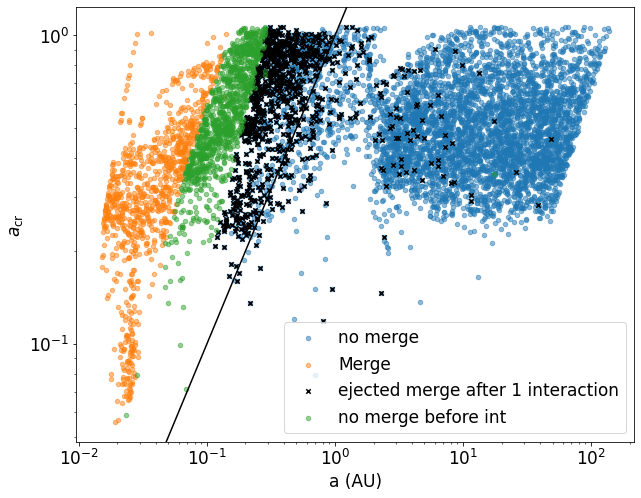

In [452]:
mergeAfterInt = temp.loc[temp['newTdelay']<=13.7e3].index


fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retained], BBH['aej'].loc[retained], s=20, color='tab:blue', alpha=0.5, label='no merge')
ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retainednMerge & mergeBeforeInt], BBH['aej'].loc[retainednMerge & mergeBeforeInt], color='tab:orange', s=20, alpha=0.5, label='Merge')
ax.scatter(BBH['SemiMajorAxis@DCO'].loc[mergeAfterInt], BBH['aej'].loc[mergeAfterInt], color='black', marker='x', s=20, label='ejected merge after 1 interaction')

ax.scatter(BBH['SemiMajorAxis@DCO'].loc[retainednMerge & ~mergeBeforeInt], BBH['aej'].loc[retainednMerge & ~mergeBeforeInt], color ='tab:green', s=20, alpha=0.5, label='no merge before int')

# Formatting Plot
ax.axline([1e-1, 1e-1], slope=1, color='black')
ax.set_xlabel('a (AU)')
ax.set_ylabel('$a_{\mathrm{cr}}$')
ax.legend(loc='lower right')

ax.set_xscale('log')
ax.set_yscale('log')

In [296]:
BBH.loc[retainednMerge, 'Coalescence_Time'] + BBH.loc[retainednMerge, '      Time      ']

3      5869.354132
20     2262.472200
42     1870.352178
54      453.663206
64       80.004377
86      155.606454
97     4235.265486
109     262.358171
110     812.191749
dtype: float64

<ipython-input-358-b6332fbdd935>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['newa'] = new_a
<ipython-input-358-b6332fbdd935>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['newTdelay'] = newTdelay


Text(0, 0.5, '$a_{\\mathrm{cr}}$')

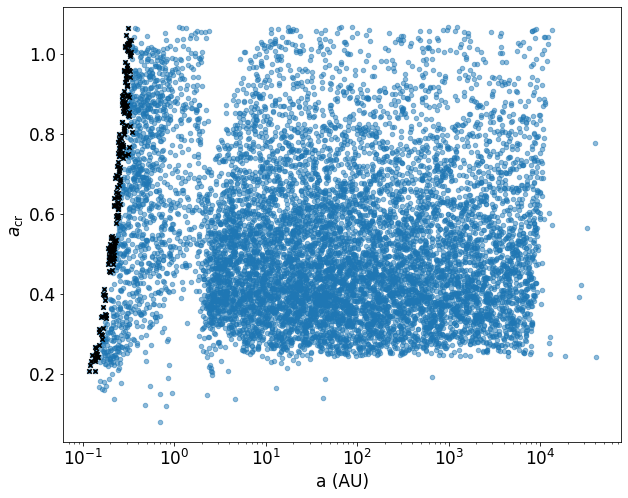

In [358]:
temp2 = BBH.loc[retained]

new_a = temp2['SemiMajorAxis@DCO']/1.2

temp2['newa'] = new_a
newTdelay = tdelay(ai=new_a*215.032, ei=temp2['Eccentricity@DCO'], m1=temp2['   Mass(1)    '], m2=temp2['   Mass(2)    '])/1e6
temp2['newTdelay'] = newTdelay

fig, ax=plt.subplots(figsize=(10,8))
ax.scatter(temp2['SemiMajorAxis@DCO'], temp2['aej'], s=20, color='tab:blue', alpha=0.5, label='no merge')
ax.scatter(temp2['SemiMajorAxis@DCO'].loc[temp2['newTdelay']<=13.7e3], temp2['aej'].loc[temp2['newTdelay']<=13.7e3], marker='x', color='black', s=20)
plt.xscale('log')
plt.xlabel('a (AU)')
plt.ylabel('$a_{\mathrm{cr}}$')

## TESTING ##


Add the values from the PeTar simulations to over plot on the pop fractions


In [11]:
# What metallicity are you running
metal = input('What is the metallicity?(sub/sol)   ')

if metal=='sub':
#     petar_total = np.array([ 5, 27, 51])
#     petar_esc = np.array([24.48523358, 43.44193551, 54.28638334])
    
    retainedBinary = np.array([ 6, 41, 73])
    retainedSingle = np.array([ 2, 25, 64])

    ##############################################
    # # This finds the escape velocity and sigma from the cluster
    petar_total = np.array([ 5, 27, 51])
    petar_esc = np.array([13.6, 34.2, 44.2]) # This is the escape velocity averaged over all BBHs at thier foramation
    
    petar_esc = np.array([11.93, 20.4, 25.4]) # This is the initial escape velocity
    
#     # # # This assumes a single BBH powers the whole cluster
#     petar_pop1 = np.array([1, 10, 15]) # No interactions
#     petar_pop2 = np.array([4, 4, 6]) # 1 interaction
#     petar_pop3 = np.array([0, 9, 15]) # Many interactions
#     petar_pop0 = np.array([0, 0, 0]) # Hard dynamical binaries 

#     petar_pop1_merge = np.array([ 1.,  10., 15.])
#     petar_pop2_mergeSE = np.array([ 0.,  3., 3.])
#     petar_pop2_mergeInt = np.array([1, 4, 6]) 
#     petar_pop3_merge = np.array([0, 0, 2])

    # # # This assumes the energy provide to the cluster is shared between all hard BBHs
    petar_pop1 = np.array([1, 13, 18]) # No interactions
    petar_pop2 = np.array([4, 1, 3]) # 1 interaction
    petar_pop3 = np.array([0, 9, 15]) # Many interactions
    petar_pop0 = np.array([0, 0, 0]) # Hard dynamical binaries 
    
    petar_pop1_merge = np.array([ 1.,  13., 18.])
    petar_pop2_mergeSE = np.array([ 0,  0., 0.])
    petar_pop2_mergeInt = np.array([0, 1, 2]) 
    petar_pop3_merge = np.array([0, 0, 1])
    
    
    # Errors calculated assuming the counts are Poisson distributed 
    petar_pop1_error = np.sqrt(petar_pop1/petar_total**2)
    petar_pop2_error = np.sqrt(petar_pop2/petar_total**2)
    petar_pop3_error = np.sqrt(petar_pop3/petar_total**2)
    petar_pop0_error = np.sqrt(petar_pop0/petar_total**2)
    petar_pop1_merge_error = np.sqrt(petar_pop1_merge/petar_total**2)
    petar_pop2_mergeSE_error = np.sqrt(petar_pop2_mergeSE/petar_total**2)
    petar_pop2_mergeInt_error = np.sqrt(petar_pop2_mergeInt/petar_total**2)
    petar_pop3_merge_error = np.sqrt(petar_pop3_merge/petar_total**2)
    
    
    
    
elif metal=='sol':
#     petar_total = np.array([ 6,  4, 27])
#     petar_esc = np.array([25.2088414 , 42.94701859, 53.89669315])
        
    retainedBinary = np.array([ 4,  7, 32])
    retainedSingle = np.array([1, 12, 39])
    
#     petar_pop1 = np.array([1, 1, 8]) # No interactions
#     petar_pop2 = np.array([4, 1, 14]) # 1 interaction
#     petar_pop3 = np.array([0, 1, 4]) # Many interactions
#     petar_pop0 = np.array([1, 0, 0]) # Hard dynamical binaries 
    
#     petar_pop1_merge = np.array([1., 1., 8.])
#     petar_pop2_mergeSE = np.array([1., 1., 9.])
#     petar_pop2_mergeInt = np.array([1., 1., 12.])
#     petar_pop3_merge = np.array([0., 0., 0.])
    
    ##############################################
    # # This finds the escape velocity and sigma from the cluster
    petar_total = np.array([ 6, 4, 27])
    petar_esc = np.array([14.9, 35.2, 44.0]) # This takes the average of the vesc for every BBH on formation time

    petar_esc = np.array([11.93, 20.4, 25.4]) # This is the initial escape velocity
    
    
    petar_pop1 = np.array([1, 1, 8]) # No interactions
    petar_pop2 = np.array([3, 1, 13]) # 1 interaction
    petar_pop3 = np.array([1, 1, 5]) # Many interactions
    petar_pop0 = np.array([1, 0, 0]) # Hard dynamical binaries 

    petar_pop1_merge = np.array([ 1.,  1., 8.])
    petar_pop2_mergeSE = np.array([ 1.,  1., 9.])
    petar_pop2_mergeInt = np.array([1, 1, 12]) 
    petar_pop3_merge = np.array([0, 0, 0])
    
    
    # Errors calculated assuming the counts are Poisson distributed 
    petar_pop1_error = np.sqrt(petar_pop1/petar_total**2)
    petar_pop2_error = np.sqrt(petar_pop2/petar_total**2)
    petar_pop3_error = np.sqrt(petar_pop3/petar_total**2)
    petar_pop0_error = np.sqrt(petar_pop0/petar_total**2)
    petar_pop1_merge_error = np.sqrt(petar_pop1_merge/petar_total**2)
    petar_pop2_mergeSE_error = np.sqrt(petar_pop2_mergeSE/petar_total**2)
    petar_pop2_mergeInt_error = np.sqrt(petar_pop2_mergeInt/petar_total**2)
    petar_pop3_merge_error = np.sqrt(petar_pop3_merge/petar_total**2)
    
elif metal=='none':
    retainedBinary = np.array([])
    retainedSingle = np.array([])
    
    # # This finds the escape velocity and sigma from the cluster
    petar_total = np.array([])
    petar_esc = np.array([])

    petar_pop1 = np.array([]) # No interactions
    petar_pop2 = np.array([]) # 1 interaction
    petar_pop3 = np.array([]) # Many interactions
    petar_pop0 = np.array([]) # Hard dynamical binaries 

    petar_pop1_merge = np.array([])
    petar_pop2_mergeSE = np.array([])
    petar_pop2_mergeInt = np.array([]) 
    petar_pop3_merge = np.array([])
    
    # Errors calculated assuming the counts are Poisson distributed 
    petar_pop1_error = np.sqrt(1)
    petar_pop2_error = np.sqrt(1)
    petar_pop3_error = np.sqrt(1)
    petar_pop0_error = np.sqrt(1)
    petar_pop1_merge_error = np.sqrt(1)
    petar_pop2_mergeSE_error = np.sqrt(1)
    petar_pop2_mergeInt_error = np.sqrt(1)
    petar_pop3_merge_error = np.sqrt(1)

What is the metallicity?(sub/sol)    sol


In [9]:
'''
Here I want to test a range of rh and Mcl such that the escape velocity remains constant
sigma = sqrt(G*Mcl/rh)

Assuming King profile with W0=7
vesc = 4.77*sigma 
'''
N = 40 # Number of points

delta=0.2 # The fraction energy change during interaction

# Fix rho
rho = 1200 # Msol/pc^3

# Vary Mcl and then find rh from density equation
Mcl = np.logspace(3, 8, N)
rh_array = ((3*Mcl)/(8*np.pi*rho))**(1/3)

# # Fix constant Mcl and vary rho and rh
Mcl = np.ones(N)*1e5 # Msol
rho_array = np.logspace(0, 7, N)

rh_array =((3*Mcl)/(8*np.pi*rho_array))**(1/3)

# Empty array for the data to be stored
data_simple = {}

# write the output to a txt file
f = open(os.path.join(dataDir, 'PopFractionOutput_fixedMcl.txt'), 'w')

# Assumed perturber mass
m3=20 # Msol 

# Empty populatation arrays
pop1frac_simple=[]
pop2frac_simple=[]
pop3frac_simple=[]
soft_simple=[]

v_esc_array=[]

# Empty retained fraction array
tot_bound = []
tot_unbound = []
total_retained = []

print('##########STARTING##########\n')
for (mass, rh) in zip(Mcl, rh_array):
    BBH_simple = BBHMaster.copy()
    
    rhoh = (mass/2)/(4/3*np.pi*rh**3)
    
    print('Mass = {:.3g} Msol'.format(mass))
    print('Rh = {:.3g} pc'.format(rh))
    print('rho = {:.3g} Msol/pc^3\n'.format(rhoh))
    
    # Properties of the cluster
#     sigma_sq = (G*Rsol2AU/pc2AU)*mass/rh # vel disp km/s
#     vesc = 4.77*np.sqrt(sigma_sq) # esc vel km/s
    fcl = 119.3 # for King cluster W0=7
    vesc = fcl * (mass/1e6)**(0.5) * (rh/1)**(-0.5)
    sigma_sq = (vesc/4.77)**2 # For King cluster model
    
    
    v_esc_array.append(vesc)
    
    print('Sigma = {:.3g} km/s'.format(np.sqrt(sigma_sq)))
    print('Vesc = {:.3g} km/s\n'.format(vesc))
    
    
    # writing to file
    f.write('Mass = {:.3g} Msol\n'.format(mass))
    f.write('Rh = {:.3g} pc\n'.format(rh))
    f.write('rho = {:.3g} Msol/pc^3\n\n'.format(rhoh))
    f.write('Sigma = {:.3g} km/s\n'.format(np.sqrt(sigma_sq)))
    f.write('Vesc = {:.3g} km/s\n\n'.format(vesc))
    
    # Calculate relaxation time for cluster
    trh = calcTrh(M=mass, rh=rh)
    
    # Classify every BBH initially as pop 0 to be changed later
    BBH_simple['Pop'] = np.zeros(len(BBH_simple))
    
    # Find the BBH's that escape solely from SN kicks
    esc=[]

    for name in BBH_simple['    SEED    ']:
        # Find both SN information
        temp = SN.loc[SN['    SEED    '] == name]

        if (temp['SystemicSpeed '].values<vesc).all():
            esc.append(0)
        elif temp['SystemicSpeed '].values[0]>=vesc:
            esc.append(1)
        elif temp['SystemicSpeed '].values[1]>=vesc:
            esc.append(2)
    
    # Add this as column
    esc = np.asarray(esc)
    BBH_simple['Escaped'] = esc
    
    # Classify as pop1
    BBH_simple['Pop'].loc[(BBH_simple['Escaped']!=0)&(BBH_simple['Merges_Hubble_Time']==1)] = int(1)

    # Find the BBHs that are hard
    # Find the ah cut off for every binary
    mu = (BBH_simple['   Mass(1)    ']*BBH_simple['   Mass(2)    '])/(BBH_simple['   Mass(1)    ']+BBH_simple['   Mass(2)    '])
    ah = (G*Rsol2AU)*mu/sigma_sq

    # Classify a binary as hard if its a < ah
    hard  = np.zeros(len(BBH_simple))
    hard[np.where(BBH_simple['SemiMajorAxis@DCO']<=ah)] = int(1)

    # Add to the BBH file
    BBH_simple['Hard'] = hard
    
    # Find number of hard BBHs if scaled to specific cluster size
    fracHard = np.sum(hard)/len(BBH_simple)
    fracBBH  = len(BBH_simple)/len(SP)
    NBBHhard = functions.scaleNumHardBBH(fracHard, fracBBH, mass)
    print(f'After scaling for Mcl={mass:.3g} Msol there are {int(NBBHhard)} hard BBHs')
    f.write(f'After scaling for Mcl={mass:.3g} Msol there are {int(NBBHhard)} hard BBHs')
    
    # Find interaction time for all binaries and add as column
    tint = calcTint(M1=BBH_simple['   Mass(1)    '], M2=BBH_simple['   Mass(2)    '], a=BBH_simple['SemiMajorAxis@DCO'], Mcl=mass, rh=rh, trh=trh, Nbin=NBBHhard, delta=delta)
    print(f'The mean interaction time is {np.mean(tint):.3g} Myrs\n' )
    f.write(f'The mean interaction time is {np.mean(tint):.3g} Myrs\n')
    
    BBH_simple['Tint']=tint
    
    print(f'{len(BBH_simple)} retained BBHs and {int(np.sum(hard))} hard BBHs\n')
    f.write(f'{len(BBH_simple)} retained BBHs and {int(np.sum(hard))} hard BBHs\n')
    
    
    # Find pop 1 binaries that don't escape but merge before an interaction
    retainedMerge = (BBH_simple['Merges_Hubble_Time']==1)&(BBH_simple['Escaped']==0)&(BBH_simple['Hard']==1)
    mergeBeforeInt = (BBH_simple['Tint']+BBH_simple['      Time      '])>BBH_simple['Coalescence_Time']
    BBH_simple['Pop'].loc[retainedMerge & mergeBeforeInt] = int(1)
    
    # Finding index for all pop1
    pop1 = BBH_simple['Pop']==1
    
    # Finding the ejection semi-major axis and add to the dataframe (assume same perturber mass for all interactions)
    aej = delta*(G)/(vesc**2)*(BBH_simple['   Mass(1)    ']*BBH_simple['   Mass(2)    '])/(BBH_simple['   Mass(1)    ']+BBH_simple['   Mass(2)    ']+m3) # Rsol
    aej*=Rsol2AU
    
    # Add as a column
    BBH_simple['aej'] = aej
    
    # In this simple model we define pop 2 as BBHs below the aej value that are not pop 1
    belowAej = (BBH_simple['SemiMajorAxis@DCO']<=BBH_simple['aej'])
    pop2 = (belowAej)&(BBH_simple['Pop']!=1)
    mergingIndex = (BBH_simple['Merges_Hubble_Time']==1)
    BBH_simple['Pop'].loc[pop2] = 2
    
        
    # Pop 3 are BBHs that are hard and so will likely merge at some point but experience more than 1 interaction and are not ejected
    pop3 = ~pop1 & ~pop2 & (BBH_simple['SemiMajorAxis@DCO']>BBH_simple['aej']) & (BBH_simple['Hard']==1)
    BBH_simple['Pop'].loc[pop3] = 3 
    
 
    total = len(BBH_simple)
    
    
    print('Pop 1 frac: {:.3g}'.format(len(BBH_simple.loc[pop1])/total))
    print('Pop 2 frac: {:.3g}'.format(len(BBH_simple.loc[pop2])/total))
    print('Pop 3 frac: {:.3g}\n'.format(len(BBH_simple.loc[pop3])/total))
    
    
    # writing to file
    f.write('Pop 1 frac: {:.3g}\n'.format(len(BBH_simple.loc[pop1])/total))
    f.write('Pop 2 frac: {:.3g}\n'.format(len(BBH_simple.loc[pop2])/total))
    f.write('Pop 3 frac: {:.3g}\n\n'.format(len(BBH_simple.loc[pop3])/total))
    
    pop1frac_simple.append(len(BBH_simple.loc[pop1])/total)
    pop2frac_simple.append(len(BBH_simple.loc[pop2])/total)

    pop3frac_simple.append(len(BBH_simple.loc[pop3])/total)
    soft_simple.append(len(BBH_simple.loc[BBH_simple['Pop']==0])/total)
    

    # Here we ensure that the primary mass is labelled as m1
    primMass = BBH_simple['   Mass(1)    ']<BBH_simple['   Mass(2)    ']
    BBH_simple.loc[primMass, ['   Mass(1)    ', '   Mass(2)    ', 'Stellar_Type(1)', 'Stellar_Type(2)']] = BBH_simple.loc[primMass, [ '   Mass(2)    ', '   Mass(1)    ', 'Stellar_Type(2)', 'Stellar_Type(1)']]    
    
    if np.unique(Mcl).size>1:
        data_simple[mass] = BBH_simple
    else:
        data_simple[rh] = BBH_simple
    
    ############################################
    # Reset the counters
    retainedSingle=0
    retainedBound=0
    
    # This last part will calculate the fraction of retained binaries (containing at least one BH) with the cluster 
    # Those systems that form a BH but the second star never goes SN
    retainedSingle+=len(BHSingUnbound.loc[BHSingUnbound['ComponentSpeed(SN)']<vesc])
    retainedBound+=len(BHSingBound.loc[BHSingBound['ComponentSpeed(SN)']<vesc])

    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]
    
    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]
    
    retainedBound+=2*len(BBHRetain)
    
    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)])
    
    # BHElse on Second
    index = BHElse['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedBound+=len(BHElse.loc[(index)&(BHElse['SystemicSpeed ']<vesc)&(BHElse['Unbound']==0)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(SN)']<vesc)&(BHElse['Stellar_Type(SN)']==14)&(BHElse['Unbound']==1)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(CP)']<vesc)&(BHElse['Stellar_Type(CP)']==14)&(BHElse['Unbound']==1)])
    
    # retainedUnbound on first
    retainedSingle+=len(retainedSN.loc[retainedSN['Stellar_Type(SN)']==14])
    
    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    retainedSingle+=len(SN2nd[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)])
    
    # Append to the fractional arrays
    totalretained=retainedSingle+retainedBound
    tot_bound.append(retainedBound)
    tot_unbound.append(retainedSingle)
    total_retained.append(totalretained)
    
    print('##############################\n')
    f.write('##############################\n')

tot_bound = np.asarray(tot_bound)
tot_unbound = np.asarray(tot_unbound)
total_retained = np.asarray(total_retained)

f.close()

##########STARTING##########

Mass = 1e+05 Msol
Rh = 22.9 pc
rho = 1 Msol/pc^3

Sigma = 1.65 km/s
Vesc = 7.89 km/s

After scaling for Mcl=1e+05 Msol there are 10 hard BBHs
The mean interaction time is 4.82e+03 Myrs

2817 retained BBHs and 2322 hard BBHs

Pop 1 frac: 0.0263
Pop 2 frac: 0.36
Pop 3 frac: 0.438

##############################

Mass = 1e+05 Msol
Rh = 19.9 pc
rho = 1.51 Msol/pc^3

Sigma = 1.77 km/s
Vesc = 8.45 km/s

After scaling for Mcl=1e+05 Msol there are 10 hard BBHs
The mean interaction time is 3.41e+03 Myrs

2817 retained BBHs and 2288 hard BBHs

Pop 1 frac: 0.0263
Pop 2 frac: 0.357
Pop 3 frac: 0.429

##############################

Mass = 1e+05 Msol
Rh = 17.4 pc
rho = 2.29 Msol/pc^3

Sigma = 1.9 km/s
Vesc = 9.06 km/s

After scaling for Mcl=1e+05 Msol there are 10 hard BBHs
The mean interaction time is 2.42e+03 Myrs

2817 retained BBHs and 2252 hard BBHs

Pop 1 frac: 0.0263
Pop 2 frac: 0.355
Pop 3 frac: 0.418

##############################

Mass = 1e+05 Msol
Rh = 15.1

In [148]:
# Loading merge data
load = input('Load data?[n]  ')
if not load:load='n'
    
if load=='y':
    which = input('fix rho(1) or fix Mcl(2)?   ')
    if which=='1':
        print('\nFixing rho')
        v_esc_array, Mcl, pop1frac_simple, pop2frac_simple, pop3frac_simple, tot_bound, total_retained  = np.genfromtxt(os.path.join(dataDir, 'fixrhoData.txt'), unpack=True)
        
    elif which=='2':
        print('\nFixing Mcl')   
        v_esc_array, Mcl, pop1frac_simple, pop2frac_simple, pop3frac_simple, tot_bound, total_retained  = np.genfromtxt(os.path.join(dataDir, 'fixMclData.txt'), unpack=True)

Load data?[n]   


In [160]:
total_retained

array([ 9057,  9255,  9479,  9745, 10032, 10358, 10711, 11072, 11439,
       11831, 12219, 12629, 13015, 13390, 13804, 14218, 14671, 15154,
       15645, 16194, 16805, 17475, 18222, 19000, 19854, 20792, 21833,
       22961, 24228, 25564, 27001, 28535, 30204, 31979, 33826, 35778,
       37756, 39878, 42043, 44237])

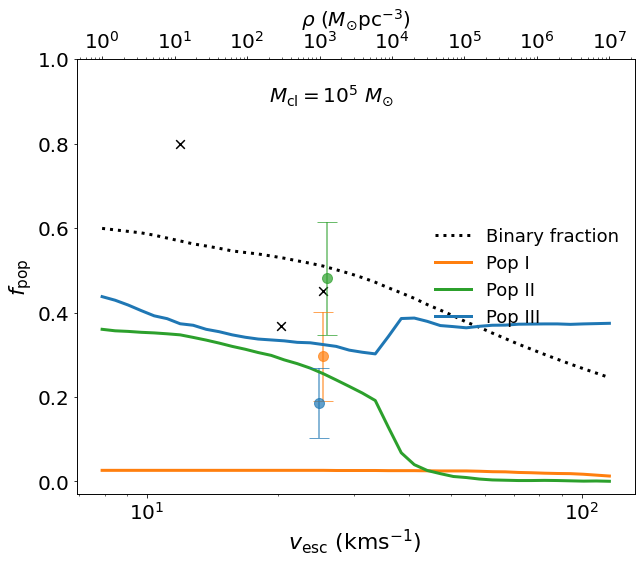

In [12]:
fig, ax = plt.subplots(figsize=(10,8))


ax.plot(v_esc_array, tot_bound/total_retained, color='black', linestyle=':', linewidth=3, label='Binary fraction')
#ax.plot(Mcl, tot_unbound/total_retained, color='black', linestyle='-')


ax.plot(v_esc_array, pop1frac_simple, color='tab:orange', linewidth=3, label='Pop I')
# ax.plot(v_esc_array, pop2frac_simple_SEmerge, color='tab:green', label='Pop 2 - SE merge', linestyle='--')
# ax.plot(v_esc_array, pop2frac_simple_intmerge, color='tab:green', label='Pop 2 - int merge', linestyle=':')
ax.plot(v_esc_array, pop2frac_simple, color='tab:green', linewidth=3, label='Pop II')
ax.plot(v_esc_array, pop3frac_simple, color='tab:blue', linewidth=3, label='Pop III')
# ax.plot(v_esc_array, soft_simple, color='black', label='Soft BBH')

##### Plot the retained binary fraction from PeTar
ax.scatter(petar_esc, retainedBinary/(retainedBinary+retainedSingle), color='black', marker='x', s=75)


# print(f'pop 1 fraction : {petar_pop1/petar_total}')
# print(f'pop 2 fraction : {petar_pop2/petar_total}')
# print(f'pop 3 fraction : {petar_pop3/petar_total}')
# print(f'pop 0 fraction : {petar_pop0/petar_total}')
# print(f'pop 0+3 fraction : {petar_pop0/petar_total+petar_pop3/petar_total}\n')


ax2 = ax.twiny()
if np.unique(Mcl).size>1:
    ax.errorbar(petar_esc, petar_pop1/petar_total, petar_pop1_error, xerr=None, fmt='x', markersize=20, capsize=10, color='tab:orange', alpha=0.7, marker='.')
    ax.errorbar(petar_esc+0.5, petar_pop2/petar_total, petar_pop2_error, xerr=None, fmt='x', markersize=20, capsize=10, color='tab:green', alpha=0.7, marker='.')
    ax.errorbar(petar_esc+1, petar_pop0/petar_total+petar_pop3/petar_total, petar_pop3_error, xerr=None, fmt='x', markersize=20, capsize=10, color='tab:blue', alpha=0.7, marker='.')

    
    ax2.plot(Mcl, pop3frac_simple, alpha=0)
    ax2.set_xscale('log')
    ax2.set_xlabel('$M_{\mathrm{cl}} \ (M_{\odot })$')
    ax2.text(5e4, 0.95, '$\\rho = 1200 \ M_{\odot}$pc$^{-3}$')
#     ax2.set_xlim(1e3, 1e8)

    # Writing data to txt file for ease of plotting later
    d = np.vstack((v_esc_array, Mcl, pop1frac_simple, pop2frac_simple, pop3frac_simple, tot_bound, total_retained)).T
    np.savetxt(os.path.join(dataDir, 'fixrhoData.txt'), d)

else:
    if metal!='none':
        ax.errorbar(petar_esc[-1], petar_pop1[-1]/petar_total[-1], petar_pop1_error[-1], xerr=None, fmt='x', markersize=20, capsize=10, color='tab:orange', alpha=0.7, marker='.')
        ax.errorbar(petar_esc[-1]+0.5, petar_pop2[-1]/petar_total[-1], petar_pop2_error[-1], xerr=None, fmt='x', markersize=20, capsize=10, color='tab:green', alpha=0.7, marker='.')
        ax.errorbar(petar_esc[-1]-0.5, petar_pop0[-1]/petar_total[-1]+petar_pop3[-1]/petar_total[-1], petar_pop3_error[-1], xerr=None, fmt='x', markersize=20, capsize=10, color='tab:blue', alpha=0.7, marker='.')


    ax2.plot(rho_array, pop3frac_simple, alpha=0)
    ax2.set_xscale('log')
    ax2.set_xlabel('$\\rho$ $(M_{\odot}$pc$^{-3})$')
    ax2.text(2e2, 0.9, '$M_{\mathrm{cl}} = 10^{5} \ M_{\odot}$')
#     ax2.set_xlim(1e0, 1e7)

    # Writing data to txt file for ease of plotting later
    d = np.vstack((v_esc_array, Mcl, pop1frac_simple, pop2frac_simple, pop3frac_simple, tot_bound, total_retained)).T
    np.savetxt(os.path.join(dataDir, 'fixMclData.txt'), d)
    


ax.legend(loc='center right', fontsize=18, frameon=False)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(-.03,1)
#ax.set_xlabel('Cluster rh ($M_{\odot}/r_{\mathrm{h}}^{3}$)')
#ax.set_xlabel('$v_{\mathrm{esc}} \ \mathrm{kms}^{-1}$ ', fontsize=22)

ax.set_xlabel('$v_{\mathrm{esc}} \ (\mathrm{kms^{-1}})$ ', fontsize=22)

ax.set_ylabel('$f_{\mathrm{pop}}$', fontsize=22);

In [13]:
if np.unique(Mcl).size>1:
    fig.savefig(os.path.join(dataDir, 'alternativePopFraction_shareenergy_fixrho.pdf'), dpi=100)
else:
    fig.savefig(os.path.join(dataDir, 'alternativePopFraction_shareenergy_fixMcl.pdf'), dpi=100)

In [14]:
'''
Splitting the pop2 into those that would merge due to SE (lower limit)
and those that would merge after the averaged affect over 10 interactions

Finding lower estimate on pop 3 merging fraction by assuming they all reach aej
calculate 10 interactions and average over
'''

pop1frac_simple_inside = []
pop1frac_simple_outside = []

pop2frac_simple_SEmerge = []
pop2frac_simple_intmerge = []

pop3frac_simple_intmerge = []

totalLower = []
totalUpper = []

# Make an empty file to write to
f = open(os.path.join(dataDir, 'MergeFractionOutputfixMcl.txt'), 'w')

count = 0
for key in data_simple.keys():
    BBH_simple = data_simple[key]
    total = len(BBH_simple)
    totalHard = len(BBH_simple.loc[BBH_simple['Hard']==1])
    
    # Find the pop1, pop2 and pop3
    pop1 = (BBH_simple['Pop']==1)
    pop2 = (BBH_simple['Pop']==2)
    pop3 = (BBH_simple['Pop']==3)
    
    # Find those that binaries that are already in a merging regime after SE
    mergingIndex = (BBH_simple['Merges_Hubble_Time']==1)
    
    # Calculating the mergers due to an interaction
    if len(BBH_simple.loc[pop2])>0:
        avgMerge = calcMergeFromInteractions(m1=BBH_simple['   Mass(1)    '].loc[pop2].values, 
                                             m2=BBH_simple['   Mass(2)    '].loc[pop2].values,
                                             semi=BBH_simple['SemiMajorAxis@DCO'].loc[pop2].values/Rsol2AU,
                                             tint=BBH_simple['Tint'].loc[pop2].values+BBH_simple['      Time      '].loc[pop2].values,
                                             N=10)
        
        # Finding the number that merge within a hubble time
        numIntMerge = len(avgMerge[avgMerge<=13.7e3])
    
    else:
        numIntMerge = 0
    
    # Lower limit for mergers is how many would merge once they reach aej
    if len(BBH_simple.loc[pop3])>0:
        # Find roughly how many interactions it takes to reach the aej
        numInt = np.round(np.log10(BBH_simple['SemiMajorAxis@DCO'].loc[pop3].values/BBH_simple['aej'].loc[pop3].values)/np.log10(1+delta))
        avgMerge = calcMergeFromInteractions(m1=BBH_simple['   Mass(1)    '].loc[pop3].values,
                                             m2=BBH_simple['   Mass(2)    '].loc[pop3].values,
                                             semi=BBH_simple['aej'].loc[pop3].values/Rsol2AU,
                                             tint=BBH_simple['Tint'].loc[pop3].values*numInt+BBH_simple['      Time      '].loc[pop3].values,
                                             N=10)
        
        numInt3Merge = len(avgMerge[avgMerge<=13.7e3])
        
    else:
        numInt3Merge = 0
        
    
    totalUpper.append(len(BBH_simple.loc[pop1]) + numIntMerge + numInt3Merge)
    totalLower.append(len(BBH_simple.loc[pop1]) + len(BBH_simple.loc[(pop2)&(mergingIndex)]) + numInt3Merge)
    
    
    print('###########################')
    print('Vesc = {:.3g} kms^-1\n'.format(v_esc_array[count]))
    print('Pop 1 mergers (inside): {}'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']==0)])))
    print('Pop 1 mergers (outside): {}\n'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']>0)])))
    
    print('Pop 2 frac merging from SE: {}'.format(len(BBH_simple.loc[(pop2)&(mergingIndex)])))
    print('Pop 2 frac merging from int: {}\n'.format(numIntMerge))
    
    print('Pop 3 frac merging from interaction once aej reached: {}\n'.format(numInt3Merge))
    
    # Writing to file 
    f.write('###########################\n')
    f.write('Vesc = {:.3g} kms^-1\n\n'.format(v_esc_array[count]))
    f.write('Pop 1 mergers (inside): {}\n'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']==0)])))
    f.write('Pop 1 mergers (outside): {}\n'.format(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']>0)])))
    
    f.write('Pop 2 frac merging from SE: {}\n'.format(len(BBH_simple.loc[(pop2)&(mergingIndex)])))
    f.write('Pop 2 frac merging from int: {}\n'.format(numIntMerge))
    
    f.write('Pop 3 frac merging from interaction once aej reached: {}\n\n'.format(numInt3Merge))
    
    pop1frac_simple_inside.append(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']==0)]))
    pop1frac_simple_outside.append(len(BBH_simple.loc[(pop1)&(BBH_simple['Escaped']>0)]))

    pop2frac_simple_SEmerge.append(len(BBH_simple.loc[(pop2)&(mergingIndex)]))
    pop2frac_simple_intmerge.append(numIntMerge)
    
    pop3frac_simple_intmerge.append(numInt3Merge)
    
    count+=1
    
pop1frac_simple_inside = np.asarray(pop1frac_simple_inside)
pop1frac_simple_outside = np.asarray(pop1frac_simple_outside)

pop2frac_simple_SEmerge = np.asarray(pop2frac_simple_SEmerge)
pop2frac_simple_intmerge = np.asarray(pop2frac_simple_intmerge)

pop3frac_simple_intmerge = np.asarray(pop3frac_simple_intmerge)

totalLower = np.asarray(totalLower)
totalUpper = np.asarray(totalUpper)

f.close()

###########################
Vesc = 7.89 kms^-1

Pop 1 mergers (inside): 0
Pop 1 mergers (outside): 74

Pop 2 frac merging from SE: 0
Pop 2 frac merging from int: 0

Pop 3 frac merging from interaction once aej reached: 0

###########################
Vesc = 8.45 kms^-1

Pop 1 mergers (inside): 0
Pop 1 mergers (outside): 74

Pop 2 frac merging from SE: 0
Pop 2 frac merging from int: 5

Pop 3 frac merging from interaction once aej reached: 0

###########################
Vesc = 9.06 kms^-1

Pop 1 mergers (inside): 0
Pop 1 mergers (outside): 74

Pop 2 frac merging from SE: 0
Pop 2 frac merging from int: 24

Pop 3 frac merging from interaction once aej reached: 0

###########################
Vesc = 9.7 kms^-1

Pop 1 mergers (inside): 0
Pop 1 mergers (outside): 74

Pop 2 frac merging from SE: 0
Pop 2 frac merging from int: 31

Pop 3 frac merging from interaction once aej reached: 0

###########################
Vesc = 10.4 kms^-1

Pop 1 mergers (inside): 0
Pop 1 mergers (outside): 74

Pop 2 fr

In [164]:
# Loading merge data
load = input('Load data?[n]  ')
if not load:load='n'
    
if load=='y':
    which = input('fix rho(1) or fix Mcl(2)?   ')
    if which=='1':
        print('\nFixing rho')
        v_esc_array, Mcl, pop1frac_simple_inside, pop1frac_simple_outside, pop2frac_simple_intmerge, pop2frac_simple_SEmerge, pop3frac_simple_intmerge, Total = np.genfromtxt(os.path.join(dataDir, 'fixrhoData_merge.txt'), unpack=True)
        
    elif which=='2':
        print('\nFixing Mcl')
        v_esc_array, Mcl, pop1frac_simple_inside, pop1frac_simple_outside, pop2frac_simple_intmerge, pop2frac_simple_SEmerge, pop3frac_simple_intmerge, Total = np.genfromtxt(os.path.join(dataDir, 'fixMclData_merge.txt'), unpack=True)

Load data?[n]   


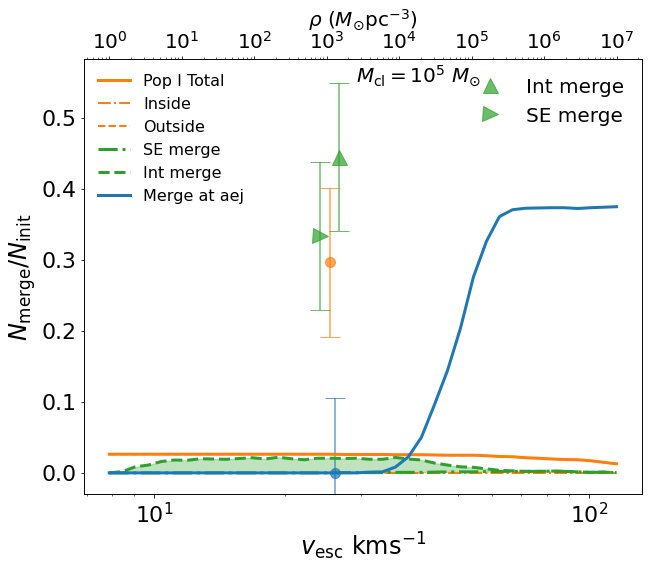

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(v_esc_array, (pop1frac_simple_inside+pop1frac_simple_outside)/total, color='tab:orange', linewidth=3, label='Pop I Total')

ax.plot(v_esc_array, pop1frac_simple_inside/total, color='tab:orange', label='Inside', linewidth=2, linestyle='-.')
ax.plot(v_esc_array, pop1frac_simple_outside/total, color='tab:orange', label='Outside', linewidth=2, linestyle='--')


ax.plot(v_esc_array, pop2frac_simple_SEmerge/total, color='tab:green', linewidth=3, label='SE merge', linestyle='-.')
ax.plot(v_esc_array, pop2frac_simple_intmerge/total, color='tab:green', linewidth=3, label='Int merge', linestyle='--')
ax.fill_between(v_esc_array, pop2frac_simple_SEmerge/total, pop2frac_simple_intmerge/total, alpha=0.3, color='tab:green')


ax.plot(v_esc_array, pop3frac_simple_intmerge/total, color='tab:blue', linewidth=3, label='Merge at aej')
# ax.fill_between(v_esc_array, pop3frac_simple_intmerge/total, pop3frac_simple_intmerge/total, alpha=0.3, color='tab:blue')



################## Plotting the PeTar points on top 


# print(petar_pop1_merge/petar_total)
# print(petar_pop2_mergeSE/petar_total)
# print(petar_pop2_mergeInt/petar_total)
# print(petar_pop3_merge/petar_total)
# print('')

ax2 = ax.twiny()
if np.unique(Mcl).size>1:
    ax.errorbar(petar_esc-0.02*petar_esc, petar_pop1_merge/petar_total, petar_pop1_merge_error, fmt='x', color='tab:orange', alpha=0.7, capsize=10, marker='.', markersize=20)
    ax.errorbar(petar_esc-0.05*petar_esc, petar_pop2_mergeSE/petar_total, petar_pop1_merge_error, fmt='x', color='tab:green', alpha=0.7, capsize=10, marker='>', markersize=15)
    ax.errorbar(petar_esc+0.05*petar_esc, petar_pop2_mergeInt/petar_total, petar_pop1_merge_error, fmt='x', color='tab:green', alpha=0.7, capsize=10, marker='^', markersize=15)
#     ax.vlines(petar_esc, petar_pop2_mergeSE/petar_total, petar_pop2_mergeInt/petar_total, color='tab:green', linestyle=':', alpha=0.5, linewidth=2)
    ax.errorbar(petar_esc+0.02*petar_esc, petar_pop3_merge/petar_total, petar_pop1_merge_error, fmt='x', color='tab:blue', alpha=0.7, capsize=10, marker='.', markersize=20)

    ax2.plot(Mcl, pop3frac_simple_intmerge/total, alpha=0)
    ax2.set_xscale('log')
    ax2.set_xlabel('$M_{\mathrm{cl}} \ (M_{\odot })$')
    ax2.text(2e6, 0.45, '$\\rho = 1200 \ M_{\odot}$pc$^{-3}$')
    
    # Writing data to txt file for ease of plotting later
    d = np.vstack((v_esc_array, Mcl, pop1frac_simple_inside, pop1frac_simple_outside, pop2frac_simple_intmerge, pop2frac_simple_SEmerge, pop3frac_simple_intmerge, np.ones_like(Mcl)*total)).T
    np.savetxt(os.path.join(dataDir, 'fixrhoData_merge.txt'), d)
    
else:
    if metal!='none':
        ax.errorbar(petar_esc[-1], petar_pop1_merge[-1]/petar_total[-1], petar_pop1_merge_error[-1], fmt='x', color='tab:orange', alpha=0.7, capsize=10, marker='.', markersize=20)
        ax.errorbar(petar_esc[-1]-0.05*petar_esc[-1], petar_pop2_mergeSE[-1]/petar_total[-1], petar_pop1_merge_error[-1], fmt='x', color='tab:green', alpha=0.7, capsize=10, marker='>', markersize=15)
        ax.errorbar(petar_esc[-1]+0.05*petar_esc[-1], petar_pop2_mergeInt[-1]/petar_total[-1], petar_pop1_merge_error[-1], fmt='x', color='tab:green', alpha=0.7, capsize=10, marker='^', markersize=15)
    #     ax.vlines(petar_esc[-1], petar_pop2_mergeSE[-1]/petar_total[-1], petar_pop2_mergeInt[-1]/petar_total[-1], color='tab:green', linestyle=':', alpha=0.5, linewidth=2)
        ax.errorbar(petar_esc[-1]+0.025*petar_esc[-1], petar_pop3_merge[-1]/petar_total[-1], petar_pop1_merge_error[-1], fmt='x', color='tab:blue', alpha=0.7, capsize=10, marker='.', markersize=20)

    
    ax2.plot(rho_array, pop3frac_simple_intmerge/total, alpha=0)
    ax2.set_xscale('log')
    ax2.set_xlabel('$\\rho$ $(M_{\odot}$pc$^{-3})$')
    ax2.text(2.5e3, 0.55, '$M_{\mathrm{cl}} = 10^{5} \ M_{\odot}$')    
    
    # Writing data to txt file for ease of plotting later
    d = np.vstack((v_esc_array, Mcl, pop1frac_simple_inside, pop1frac_simple_outside, pop2frac_simple_intmerge, pop2frac_simple_SEmerge, pop3frac_simple_intmerge, np.ones_like(Mcl)*total)).T
    np.savetxt(os.path.join(dataDir, 'fixMclData_merge.txt'), d)

lines = [Line2D([0],[0], linewidth=0, marker='^', markersize=15, alpha=0.7, color='tab:green'),
           Line2D([0],[0], linewidth=0, marker='>', markersize=15, alpha=0.7, color='tab:green')]
leg2 = Legend(ax, lines, frameon=False, loc='upper right', labels=['Int merge', 'SE merge'])
ax.add_artist(leg2)
    
ax.legend(loc='upper left', fontsize=16, frameon=False)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(-0.03, None)
#ax.set_xlabel('Cluster rh ($M_{\odot}/r_{\mathrm{h}}^{3}$)')
ax.set_xlabel('$v_{\mathrm{esc}} \ \mathrm{kms}^{-1}$', fontsize=24)

#ax.set_xlabel('$M_{\mathrm{cl}} \ (M_{\odot})$ ', fontsize=22)

ax.set_ylabel('$N_{\mathrm{merge}}/N_{\mathrm{init}}$', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=22)

In [27]:
if np.unique(Mcl).size>1:
    fig.savefig(os.path.join(dataDir, 'alternateMergeFrac_shareenergy_fixrho.pdf'), dpi=100)
else:
    fig.savefig(os.path.join(dataDir, 'alternateMergeFrac_shareenergy_fixMcl.pdf'), dpi=100)    